In [2]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'

from scipy.optimize import curve_fit


## How do animals progress their behavior with subsequent sessions?

In [3]:
date = datetime.date.today()
date_string = "10/11/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()
mouse = '745301'

In [4]:
session_n = 0
cum_active_site = pd.DataFrame()
cum_velocity = pd.DataFrame()
cum_torque = pd.DataFrame()

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)

# All this segment is to find the correct session without having the specific path
for file_name in sorted_files:
    # Find specific session sorted by date
    session = file_name[-15:-7]
    if datetime.datetime.strptime(session, "%Y%m%d").date() < date:
        continue
    else:
        session_n += 1
        print(file_name)
        
    # Recover data streams
    session_path = os.path.join(base_path, mouse, file_name)
    session_path = Path(session_path)
    data = parse.load_session_data(session_path)
    
    # Parse data into a dataframe with the main features
    reward_sites, active_site, config = parse.parse_dataframe(data)
    # -- At this step you can save the data into a csv file
    
    # Expand with extra columns
    reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
    active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

    # Load the encoder data separately
    stream_data = parse.ContinuousData(data)
    encoder_data = stream_data.encoder_data
    odor_triggers = stream_data.odor_triggers
    software_tone = data['software_events'].streams['ChoiceFeedback'].data.index
    choice_tone = stream_data.choice_feedback.index

    experiment = data['config'].streams.tasklogic_input.data['stage_name']

    # Recover color palette
    color_dict_label = {}
    dict_odor = {}
    list_patches = parse.TaskSchemaProperties(data).patches
    for i, patches in enumerate(list_patches):
        color_dict_label[patches['label']] = odor_list_color[i]
        dict_odor[i] = patches['label']
    
    if active_site.loc[active_site.label == 'InterPatch'].length.min() == 50:
        section = 'PostPatch'
    else:
        print(experiment)
        section = 'InterPatch'

    if section == 'PostPatch':
        active_site['active_patch'] = active_site['active_patch'].shift(-1)
    active_site['end_epoch'] = active_site.index.to_series().shift(-1)
    active_site['epoch_duration'] = active_site['end_epoch'] - active_site.index

    new_active_site = active_site[active_site['label'] == section]
    
    new_active_site['session_n'] = session_n
    new_active_site['experiment'] = experiment
    cum_active_site = pd.concat([cum_active_site, new_active_site])
    
    velocity = plotting.trial_collection(new_active_site, 
                                                    encoder_data, 
                                                    mouse, 
                                                    session, 
                                                    window=[-1,10],  
                                                    cropped_to_length='epoch',
                                                    taken_col='filtered_velocity')

    velocity['cropped'] = velocity.times < min(velocity.groupby('active_patch').times.max())
    velocity['session_n'] = session_n
    velocity['experiment'] = experiment
    cum_velocity = pd.concat([cum_velocity, velocity])

    torque_data = stream_data.torque_data
    brake_data = stream_data.brake_data
    
    velocity = plotting.trial_collection(new_active_site, 
                                                    torque_data, 
                                                    mouse, 
                                                    session, 
                                                    window=[-1,10],  
                                                    cropped_to_length='epoch',
                                                    taken_col=['Torque'])


    velocity_end = plotting.trial_collection(new_active_site, 
                                                    torque_data, 
                                                    mouse, 
                                                    session, 
                                                    aligned='end_epoch',
                                                    window=[-5,2],  
                                                    taken_col=['Torque'])
    
    velocity['align'] = 'onset'
    velocity_end['align'] = 'offset'
    cum_torque = pd.concat([cum_torque, velocity])
    cum_torque = pd.concat([cum_torque, velocity_end])
    # plt.ylim(0, 40)

745301_20241011T132858
data_collection
745301_20241014T132213
data_collection
745301_20241015T131218
data_collection
745301_20241016T131002
data_collection
745301_20241017T131427
control
745301_20241018T132449
control
745301_20241020T132121
745301_20241021T130542
745301_20241022T130826
745301_20241023T131315
745301_20241024T125753
745301_20241025T132331
745301_20241026T123909
745301_20241027T125335
745301_20241028T132001


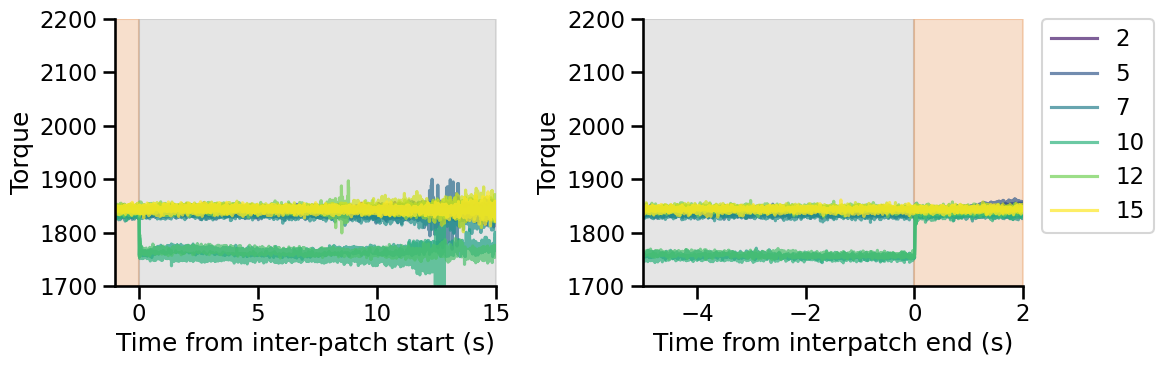

In [5]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)

sns.lineplot(data=cum_torque.loc[cum_torque['align'] =='onset'], x='times', y='Torque', hue='session_n', 
             errorbar=None, legend=False, alpha=0.7,palette='viridis')
plt.xlim(-1, 15)
plt.ylim(1700, 2200)
sns.despine()
plt.fill_betweenx([1700, 2200], -1, 0, color=color1, alpha=0.2)
plt.fill_betweenx([1700, 2200],0, 15, color='grey', alpha=0.2)
plt.xlabel('Time from inter-patch start (s)')

fig.add_subplot(122)
sns.lineplot(data=cum_torque.loc[cum_torque['align'] =='offset'], x='times', y='Torque',  hue='session_n', 
             errorbar=None, alpha=0.7, palette='viridis')
plt.xlim(-5, 2) 
plt.ylim(1700, 2200)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.fill_betweenx([1700, 2200], -15, 0, color='grey', alpha=0.2)
plt.fill_betweenx([1700, 2200], 0, 2, color=color1, alpha=0.2)
plt.xlabel('Time from interpatch end (s)')
sns.despine()
plt.tight_layout()
plt.show()

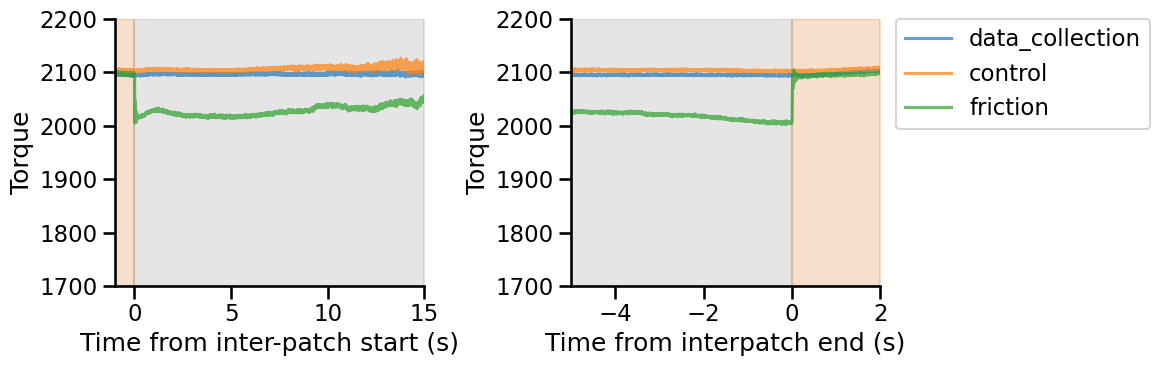

In [69]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)

sns.lineplot(data=cum_torque.loc[cum_torque['align'] =='onset'], x='times', y='Torque', hue='experiment', errorbar=None, legend=False, alpha=0.7)
plt.xlim(-1, 15)
plt.ylim(1700, 2200)
sns.despine()
plt.fill_betweenx([1700, 2200], -1, 0, color=color1, alpha=0.2)
plt.fill_betweenx([1700, 2200],0, 15, color='grey', alpha=0.2)
plt.xlabel('Time from inter-patch start (s)')

fig.add_subplot(122)
sns.lineplot(data=cum_torque.loc[cum_torque['align'] =='offset'], x='times', y='Torque',  hue='experiment', errorbar=None, alpha=0.7)
plt.xlim(-5, 2)
plt.ylim(1700, 2200)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.fill_betweenx([1700, 2200], -15, 0, color='grey', alpha=0.2)
plt.fill_betweenx([1700, 2200], 0, 2, color=color1, alpha=0.2)
plt.xlabel('Time from interpatch end (s)')
sns.despine()
plt.tight_layout()
plt.show()

Text(0.5, 398.0416666666667, 'Time from inter-patch start (s)')

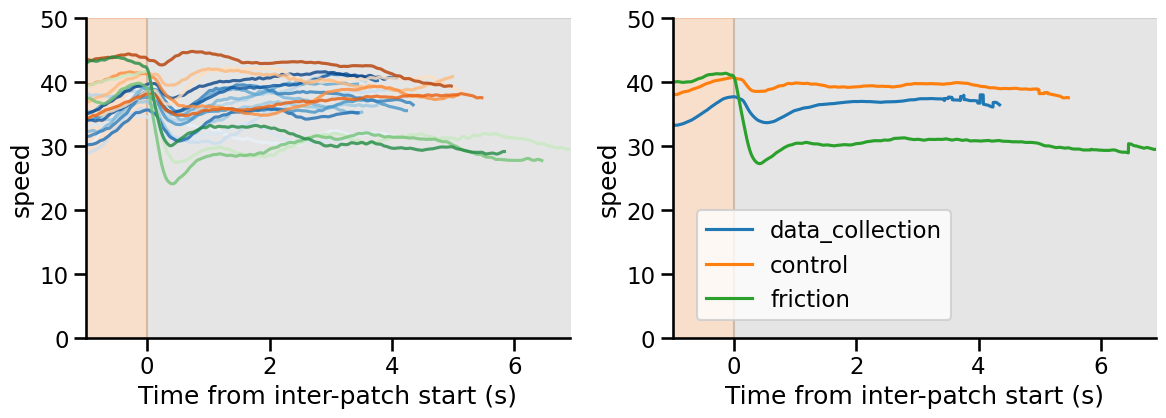

In [70]:
fig = plt.figure(figsize=(12,8))

fig.add_subplot(2,2,1)
for experiment, colors in zip(cum_velocity.experiment.unique(), ['Blues', 'Oranges', 'Greens']):
    sns.lineplot(data=cum_velocity.loc[(cum_velocity.cropped==True)&(cum_velocity.experiment==experiment)], x='times', y='speed', 
                 hue='session', palette=colors, errorbar=None, legend=False, alpha=0.8)
plt.xlim(-1, max(cum_velocity.loc[cum_velocity.cropped==True].times))
plt.ylim(0, 50)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()
plt.fill_betweenx([-5, 50], -1, 0, color=color1, alpha=0.2)
plt.fill_betweenx([-5, 50],0, 15, color='grey', alpha=0.2)
plt.xlabel('Time from inter-patch start (s)')

fig.add_subplot(2,2,2)
sns.lineplot(data=cum_velocity.loc[cum_velocity.cropped==True], x='times', y='speed', hue='experiment',  errorbar=None, legend=True)
plt.xlim(-1, max(cum_velocity.loc[cum_velocity.cropped==True].times))
plt.ylim(0, 50)
plt.legend(bbox_to_anchor=(0.05, 0.4), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()
plt.fill_betweenx([-5, 50], -1, 0, color=color1, alpha=0.2)
plt.fill_betweenx([-5, 50],0, 15, color='grey', alpha=0.2)
plt.xlabel('Time from inter-patch start (s)')

(0.0, 60.0)

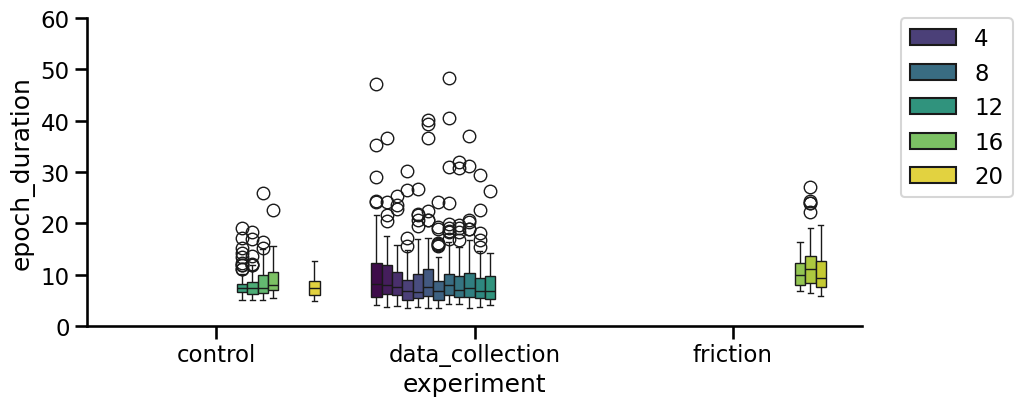

In [68]:
df_results = cum_active_site.groupby(['experiment','active_patch', 'session_n']).agg({'epoch_duration' : 'median'}).reset_index()

fig = plt.figure(figsize=(10,4))
sns.boxplot(data=df_results, x='experiment', y='epoch_duration', hue='session_n', palette='viridis')
# plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.ylim(0, 60)